## 2: Pré-processamento & Modelagem

Pré-processamento do dataset: *Credit Card Fraud Detection*.

**Link**: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Modelos avaliados: *Random Forest* & *Logistic Regression*

---
### 1️⃣ Importando Bibliotecas & Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Salvar modelo treinado
import joblib
import os
from datetime import datetime

# Data preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Strategies
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Silenciar avisos na célula de treinamento
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carregar dados
df = pd.read_csv("train.csv")
X = df.drop(["Class", "id"], axis=1)
y = df["Class"]

In [3]:
# Split dos dados
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

---
### 2️⃣ Pré-processamento
> Aplicação dos resultados avaliados no EDA

In [4]:
def remove_extreme_outliers(X, y, features=["V12", "V14"], factor=1.5):

    X_res, y_res = X.copy(), y.copy()

    for feat in features:
        fraud_data = X_res[y_res == 1][feat]
        q25, q75 = np.percentile(fraud_data, 25), np.percentile(fraud_data, 75)
        iqr = q75 - q25
        cut_off = iqr * factor
        lower, upper = q25 - cut_off, q75 + cut_off
        
        outliers = X_res[(y_res == 1) & ((X_res[feat] < lower) | (X_res[feat] > upper))].index
        X_res = X_res.drop(outliers)
        y_res = y_res.drop(outliers)
    return X_res, y_res

In [5]:
# Removendo outliers
X_train, y_train = remove_extreme_outliers(X_train_full, y_train_full)

print(f"Dataset reduzido em {len(X_train_full) - len(X_train)} outliers.")

Dataset reduzido em 9 outliers.


In [6]:
# Escalonamento
preprocessor = ColumnTransformer(transformers=[
    ("std_scaler", StandardScaler(), ["Time"]),
    ("rob_scaler", RobustScaler(), ["Amount"])
], remainder="passthrough")

---
### 3️⃣ Pipelines (Múltiplas Abordagens) & Treinamentos

- Modelo de *Logistic Regression* escolhido como Baseline, pois como a análise do Notebook de EDA sugere, seu desempenho nesse dataset não deve ser muito elevado.

- Modelo de *Random Florest* escolhido por ser um modelo baseado em árvore, que tende a desempenhar bem em datasets com alto desbalanceamento.

In [7]:
# Definindo validação cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hiperparâmetros para Logistic Regression
param_grid_lr = {
    "classifier__C": [00.1, 0.1, 1, 10, 100],
    "classifier__solver": ["lbfgs", "saga"],
    "classifier__class_weight": [None, "balanced"]
}

# Hiperparâmetros para Random Forest
param_grid_rf = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__class_weight": [None, "balanced"],
}

# Função para aplicar GridSearch em todos os modelos
def run_experiment(name, sampler, model, params):
    print(f"Executando: {name}...")

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("sampler", sampler),
        ("classifier", model)
    ])

    grid = GridSearchCV(pipeline, params, cv=skf, scoring="roc_auc", n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    return grid

In [8]:
# Estrutura para armazenar os melhores modelos e resultados
results = {}

print(f"Iniciando treinamentos...\n")

lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)

# 1. Baseline sem sampler (Apenas pesos)
results["LR_Weight"] = run_experiment("LR_Weight", "passthrough", lr, param_grid_lr)
results["RF_Weight"] = run_experiment("RF_Weight", "passthrough", rf, param_grid_rf)

# 2. RandomUnderSampling (Undersampling) + Pesos
results["LR_RUS"] = run_experiment("LR_RUS", RandomUnderSampler(random_state=42), lr, param_grid_lr)
results["RF_RUS"] = run_experiment("RF_RUS", RandomUnderSampler(random_state=42), rf, param_grid_rf)

# 3. Oversampling com SMOTE
results["LR_SMOTE"] = run_experiment("LR_SMOTE", SMOTE(sampling_strategy=0.2, random_state=42), lr, param_grid_lr)
results["RF_SMOTE"] = run_experiment("RF_SMOTE", SMOTE(sampling_strategy=0.2, random_state=42), rf, param_grid_rf)

Iniciando treinamentos...

Executando: LR_Weight...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Executando: RF_Weight...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Executando: LR_RUS...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Executando: RF_RUS...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Executando: LR_SMOTE...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Executando: RF_SMOTE...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


---
#### 📝 Sobre os Hiperparâmetros

- Testei aumentar o `classifier__n_estimators` para até 200, porém a diferença foi insignificante e o tempo de treinamento aumentou drásticamente.

- O modelo de Random Forest também possui uma opção de `class_weight` chamada `balanced_subsample`, que balanceia os dados de cada árvore individualmente, visto que cada árvore é treinada com um conjunto do dados, mas isso tende a piorar o desempenho do modelo em situações com alto desbalanceamento, pois é possível ocorrer árvores com quase nenhum dado da classe minoritária.

- O modelo de *Logistic Regression* é treinado mais rapidamente e tende a ter o pior desempenho. Dessa forma, buscando extrair o máximo do seu potencial foi colocado uma lista de vários valores para o `classifier__C`.

- O `SMOTE` não foi usado em sua totalidade, pelo desbalanceamento muito grande do dataset, ocasionava a geração de muitos dados sintéticos, que além de aumentar muito o tempo de treinamento, diminuía o desempenho pela criação de dados pouco representativos da realidade (testei valores que não aumentassem muito o tempo de treinamento e apresentassem uma melhora significativa no `ROC-AUC`).

---
### 4️⃣ Avaliação & Comparação
> Métrica comparativa: ROC-AUC

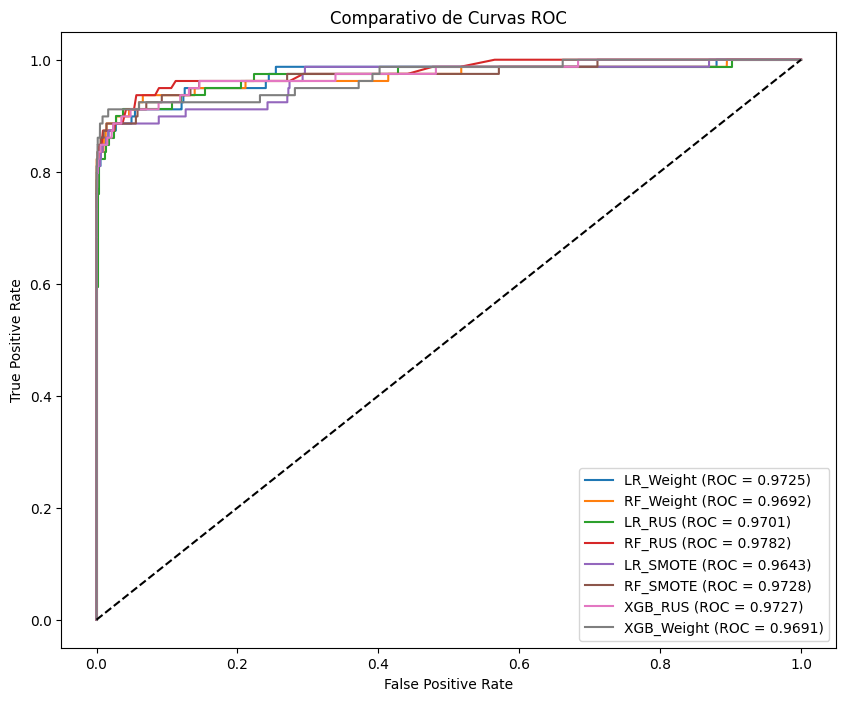

O melhor modelo foi RF_RUS com ROC 0.9782


In [12]:
best_roc = 0
best_model_name = ""

plt.figure(figsize=(10, 8))

for name, model in results.items():

    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, label=f'{name} (ROC = {roc:.4f})')

    if roc > best_roc:
        best_roc = roc
        best_model_name = name

# Gráfico   
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparativo de Curvas ROC')
plt.legend()
plt.show()

print(f"O melhor modelo foi {best_model_name} com ROC {best_roc:.4f}")

---
#### 💬 Análise sobre desempenho dos modelos

Como era de se esperar o modelo de *Random Forest* superou o baseline em todas as três abordagens, e obteve seu melhor resultado utilizando o `SMOTE` para geração de dados sintéticos.

Que como previsto foi o pior resultado para o modelo de *Logistic Regression* que sem a criação de dados adicionais, já tinha dificuldade em lidar com ruídos, e construir uma linha que conseguisse separar as "Fraudes" & "Não Fraudes". 

---
#### ➕ Treinamento de Modelo Extra

O XGBoost é um modelo que também faz parte dos modelos baseados em árvores, assim como o *Random Forest*, que desde a análise do EDA, já demonstrava um potencial maior de desempenho, em relação ao baseline: *Logistic Regression*.

- No *Random Forest*, é feito um trabalho de árvores independentes construídas em paralelo (Bagging). 
- No *XGBoost*, é feito árvores sequenciais que são treinadas para corrigir o erro das anteriores (Gradient Boosting).

> Pelo ótimo desempenho encontrado com o *Random Forest*, pode ser que o *XGBoost* consiga uma melhora percentual significativa

In [13]:
from xgboost import XGBClassifier

param_grid_xgb = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [3, 6],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__subsample": [0.8, 1.0],
}

# 1. RandomUnderSampling (Melhor resultado do RF)
results["XGB_RUS"] = run_experiment("XGB_SMOTE", RandomUnderSampler(random_state=42), 
                                      XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"), 
                                      param_grid_xgb)

param_grid_xgb_weight = {
    "classifier__n_estimators": [50, 100],
    "classifier__max_depth": [3, 6],
    "classifier__learning_rate": [0.01, 0.1],
    "classifier__scale_pos_weight": [1, 5, 10],
    "classifier__subsample": [0.8, 1.0]
}

# 2. Sem sampler + "Cost-Sensitive" (Punição por erros)
results["XGB_Weight"] = run_experiment("XGB_Weight", "passthrough", 
                                      XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"), 
                                      param_grid_xgb_weight)


Executando: XGB_SMOTE...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Executando: XGB_Weight...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x761b0b9ccad0>>
Traceback (most recent call last):
  File "/home/gabriel/Documents/ML_FraudDetection/env/lib/python3.12/site-packages/xgboost/core.py", line 607, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7290a58e7ad0>>
Traceback (most recent call last):
  File "/home/gabriel/Documents/ML_FraudDetection/env/lib/python3.12/site-packages/xgboost/core.py", line 607, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 
Fatal glibc error: malloc.c:4196 (_int_malloc): assertion failed: chunk_main_arena (fwd)
Fatal Python error: Aborted

Current thread 0x0000761b200

KeyboardInterrupt: 

> Aplicar duas técnicas de compensação ao mesmo tempo pode enviesar demais o modelo, em direção a classe minoritária (por isso são dois Grid de Hiperparâmetros distintos)

---
#### 🔎 Visualização de Resultados
> Comparando melhor modelo (*RF_SMOTE*) com modelos do XGBoost (SMOTE & Weight)

AttributeError: 'NoneType' object has no attribute 'predict_proba'

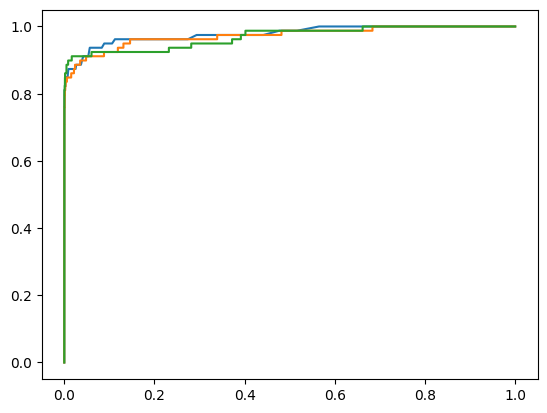

In [11]:
models = ["RF_RUS", "XGB_RUS", "XGB_Weight", "XGB_SMOTE"]

for model_name in models:

    model= results.get(model_name)

    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, label=f"{model_name} (ROC = {roc:.4f})")

# Gráfico
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparativo de Curvas ROC")
plt.legend()
plt.show()

> No fim, o melhor resultado apresentado foi realmente do *XGBoost*

O uso da técnica de `SMOTE` no modelo do XGBoost teve um desempenho levemente pior que no modelo de *Random Forest*, porém com o Hiperparâmetro `scale_pos_weight`que penaliza erros na classe minoritária durante o treinamento, foi possível obter uma melhora significativa, ficando assim como o melhor modelo em comparativo a métrica de *ROC-AUC*.

A "derrota" do modelo com `SMOTE`, demonstra que as features originais já são informativas o suficiente para o XGBoost e que o `SMOTE`adiciona um ruído que deprecia a qualidade final do modelo.

---
### 5️⃣ Salvando Modelo e Métricas

- Arquivo `.pkl` com o melhor modelo (XGBoost com abordagem de "Cost Sensitive")
- Arquivo `.csv` com as métricas e Hiperparâmetros dos melhores modelos de *Random Forest* e *XGBoost*

In [ ]:
folder_path = "./Model"
timestamp = datetime.now().strftime("%d-%H:%M:%S")    

model = results.get("RF_RUS")

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

current_best_metrics = {
    'timestamp': timestamp,
    'model_name': best_model_name,
    'roc_auc': roc,
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'best_params': str(model.best_params_) if hasattr(model, 'best_params_') else "N/A"
}


model_filename = f"{best_model_name}_{timestamp}.pkl"
model_path = os.path.join(folder_path, model_filename)
joblib.dump(model, model_path)

csv_path = os.path.join(folder_path, "history_metrics.csv")
df_metrics = pd.DataFrame([current_best_metrics])

if not os.path.exists(csv_path):
    df_metrics.to_csv(csv_path, index=False)
else:
    df_metrics.to_csv(csv_path, mode="a", header=False, index=False)

print(f"Arquivos salvos com sucesso:\n- {model_path} \n- {csv_path}")